In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv("./data/SH600000.csv", index_col = 0)
df=df.dropna()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1895 entries, SH600000 to SH600000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         1895 non-null   object 
 1   $close           1895 non-null   float64
 2   $volume          1895 non-null   float64
 3   Ref($close, 1)   1895 non-null   float64
 4   Mean($close, 3)  1895 non-null   float64
 5   $high-$low       1895 non-null   float64
dtypes: float64(5), object(1)
memory usage: 103.6+ KB


,datetime,$close,$volume,"Ref($close, 1)","Mean($close, 3)",$high-$low
instrument,,,,,,
SH600000,2010-01-04,4.260015,329246200.0,4.360537,4.323008,0.142738
SH600000,2010-01-05,4.292182,572764200.0,4.260015,4.304245,0.158820
SH600000,2010-01-06,4.207747,481411870.0,4.292182,4.253315,0.084436
SH600000,2010-01-07,4.113258,423977760.0,4.207747,4.204396,0.148772
SH600000,2010-01-08,4.159496,326840300.0,4.113258,4.160167,0.100523


In [3]:
df.describe()

,$close,$volume,"Ref($close, 1)","Mean($close, 3)",$high-$low
count,1895.000000,1.895000e+03,1895.000000,1895.000000,1895.000000
mean,5.396797,2.690322e+08,5.394342,5.394345,0.128484
std,2.385334,2.839251e+08,2.384005,2.382952,0.110308
min,2.631039,1.478025e+07,2.631039,2.644607,0.017554
25%,3.454190,9.127393e+07,3.454190,3.449220,0.059676
50%,3.998830,1.810425e+08,3.998830,4.001029,0.092871
75%,8.229271,3.288212e+08,8.224202,8.202203,0.151503
max,9.804947,2.603149e+09,9.804947,9.738440,0.956378


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1895 entries, SH600000 to SH600000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         1895 non-null   object 
 1   $close           1895 non-null   float64
 2   $volume          1895 non-null   float64
 3   Ref($close, 1)   1895 non-null   float64
 4   Mean($close, 3)  1895 non-null   float64
 5   $high-$low       1895 non-null   float64
dtypes: float64(5), object(1)
memory usage: 103.6+ KB


In [5]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df["$high-$low"] = min_max_scaler.fit_transform(df["$high-$low"].values.reshape(-1,1))
    df["$close"] = min_max_scaler.fit_transform(df["$close"].values.reshape(-1,1))
    df["Ref($close, 1)"] = min_max_scaler.fit_transform(df["Ref($close, 1)"].values.reshape(-1,1))
    df["Mean($close, 3)"] = min_max_scaler.fit_transform(df["Mean($close, 3)"].values.reshape(-1,1))
    df["$volume"] = min_max_scaler.fit_transform(df["$volume"].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):#滑动窗口大小
    data_raw = stock.values # convert to numpy array
    data = []
    valid_set_size_percentage=30
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    train_set_size = data.shape[0] - valid_set_size;
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:,:-1,:]
    y_valid = data[train_set_size:,-1,:]
    
    
    return x_train, y_train, x_valid, y_valid

# choose one stock

df_stock = df.copy()
df_stock.drop(['datetime'],axis=1,inplace=True)
cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)


# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)

df_stock.columns.values =  ['$close', '$volume', 'Ref($close, 1)', 'Mean($close, 3)', '$high-$low']
x_train.shape =  (1313, 19, 5)
y_train.shape =  (1313, 5)
x_valid.shape =  (562, 19, 5)
y_valid.shape =  (562, 5)


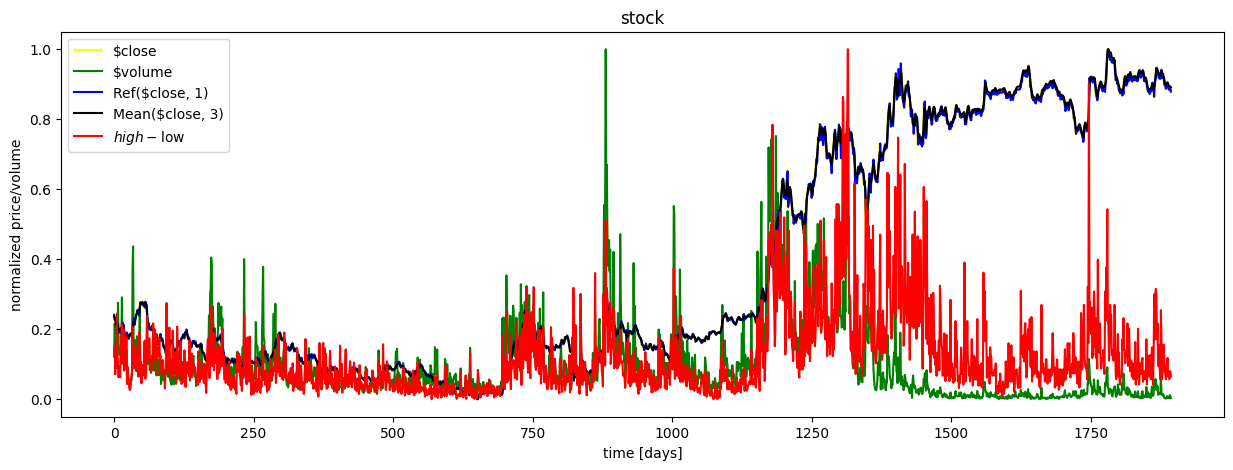

In [6]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm["$close"].values, color='yellow', label='$close')
plt.plot(df_stock_norm["$volume"].values, color='green', label='$volume')
plt.plot(df_stock_norm["Ref($close, 1)"].values, color='blue', label='Ref($close, 1)')
plt.plot(df_stock_norm["Mean($close, 3)"].values, color='black', label='Mean($close, 3)')
plt.plot(df_stock_norm["$high-$low"].values, color='red', label='$high-$low')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
model=None

In [8]:
# 定义超参数
input_size = 5  # 输入特征的维度
hidden_size = 5  # RNN隐藏状态的大小
num_layers = 15  # RNN的层数
output_size = 5  # 输出特征的维度
learning_rate = 0.005
num_epochs = 100

# 创建RNN模型
model = SimpleLSTM(input_size, hidden_size, num_layers, output_size)

# 定义均方误差损失函数和Adam优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 准备训练数据（假设已经有训练数据x_train和y_train）
# x_train是训练数据的特征，y_train是对应的标签

# 将训练数据转换为PyTorch张量
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
# 创建空列表以存储训练集和验证集的损失
train_losses = []
valid_losses = []

# 创建空列表以存储梯度变化
gradient_changes = []

# 开始训练循环
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_train)
    loss = criterion(outputs[:,-1], y_train[:,-1])###########
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    
    # 保存梯度变化
    grad_norm = 0.0
    for param in model.parameters():
        grad_norm += torch.norm(param.grad.data)
    gradient_changes.append(grad_norm.item())
    
    optimizer.step()
    
    # 在验证集上计算损失
    with torch.no_grad():
        model.eval()
        valid_outputs = model(x_valid)
        valid_loss = criterion(valid_outputs[:,-1], y_valid[:,-1])#######
        valid_losses.append(valid_loss.item())
        model.train()

    # 保存训练集的损失
    train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}')


Epoch [10/100], Train Loss: 0.0120, Valid Loss: 0.0218
Epoch [20/100], Train Loss: 0.0133, Valid Loss: 0.0235
Epoch [30/100], Train Loss: 0.0123, Valid Loss: 0.0176
Epoch [40/100], Train Loss: 0.0121, Valid Loss: 0.0187
Epoch [50/100], Train Loss: 0.0121, Valid Loss: 0.0203
Epoch [60/100], Train Loss: 0.0120, Valid Loss: 0.0191
Epoch [70/100], Train Loss: 0.0120, Valid Loss: 0.0191
Epoch [80/100], Train Loss: 0.0120, Valid Loss: 0.0195
Epoch [90/100], Train Loss: 0.0120, Valid Loss: 0.0192
Epoch [100/100], Train Loss: 0.0120, Valid Loss: 0.0193


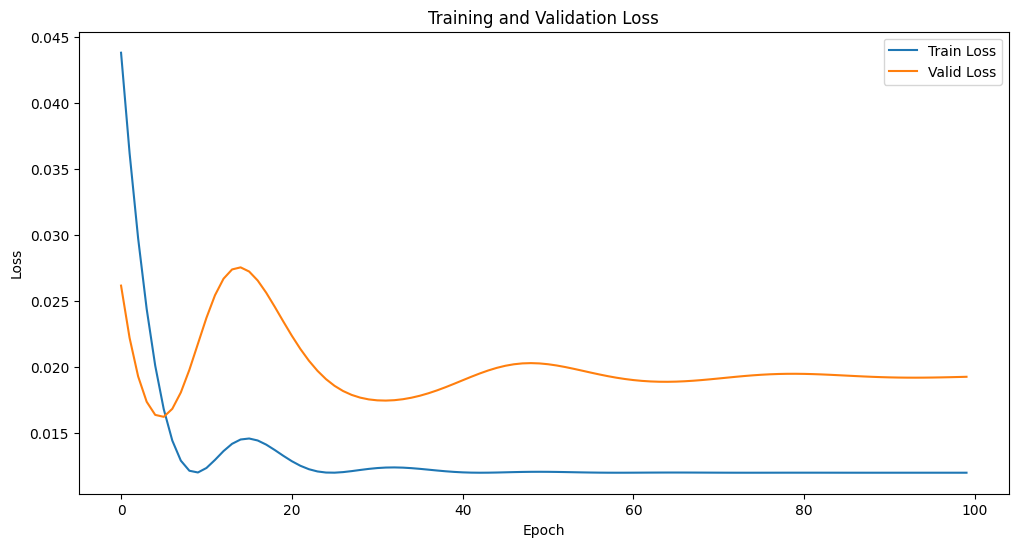

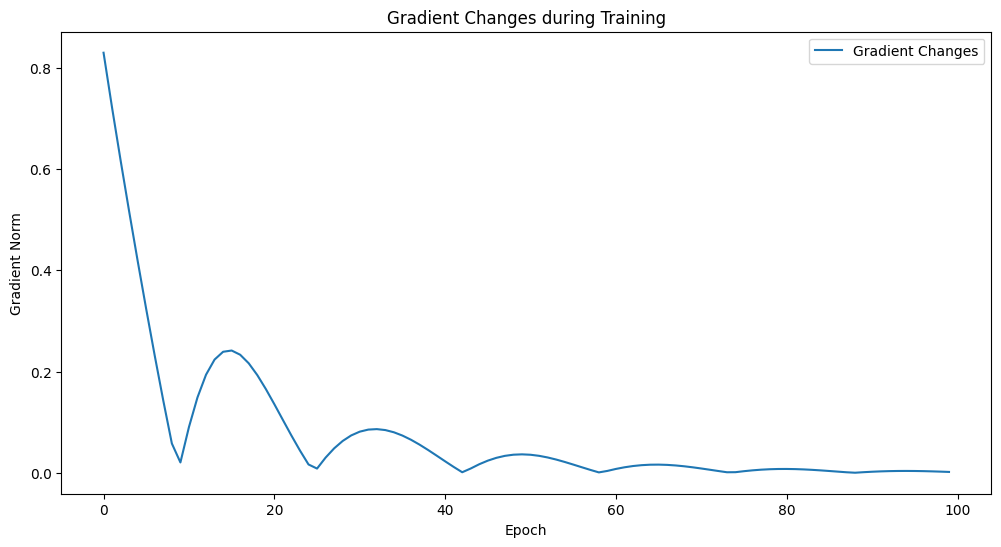

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(gradient_changes, label='Gradient Changes')
plt.title('Gradient Changes during Training')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

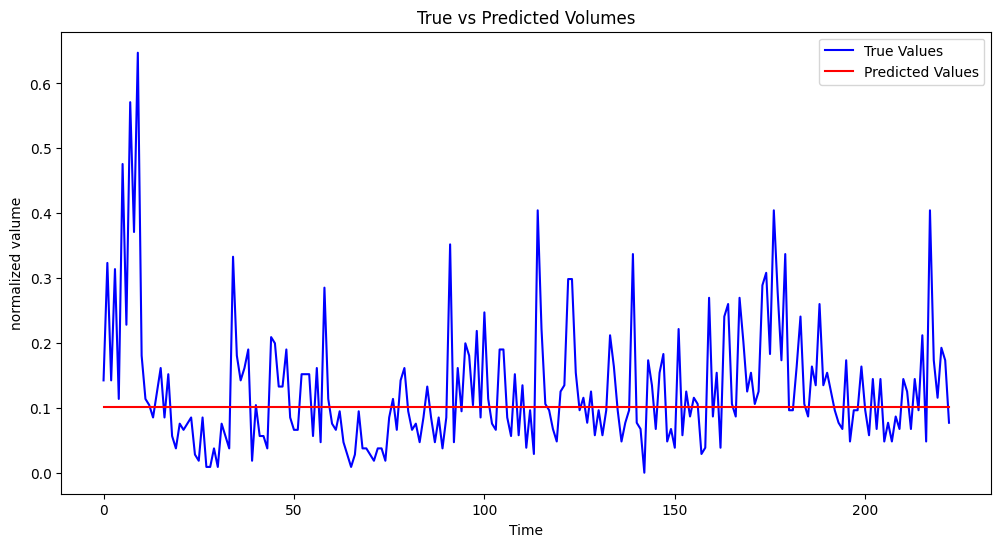

Mean Squared Error (MSE): 0.010169601999223232


In [10]:
df1 = pd.read_csv("./data/SH600000TE.csv", index_col = 0)
def load_test_data(stock, seq_len):
    data_raw = stock.values  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)

    # Use the entire data for the test set
    x_test = data[:, :-1, :]
    y_test = data[:, -1, :]

    # Convert to PyTorch tensors
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return x_test, y_test

df_stock1 = df1.copy()
df_stock1.drop(['datetime'],axis=1,inplace=True)
cols = list(df_stock1.columns.values)
df_stock_norm1 = df_stock1.copy()
df_stock_norm1 = normalize_data(df_stock_norm1)

seq_len = 20 # choose sequence length
x_test, y_test= load_test_data(df_stock_norm1, seq_len)
with torch.no_grad():
    prediction = model(x_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:,-1], label='True Values', color='blue')
plt.plot(prediction[:,-1], label='Predicted Values', color='red')
plt.title('True vs Predicted Volumes')
plt.xlabel('Time')
plt.ylabel('normalized valume')
plt.legend()
plt.show()
import torch.nn.functional as F
mse = F.mse_loss(prediction[:,-1], y_test[:,-1])

print(f'Mean Squared Error (MSE): {mse.item()}')